<a href="https://colab.research.google.com/github/jatoogunhyo/sec_edgar/blob/main/%EC%9E%90%EC%82%AC%EC%A3%BC_%EC%86%8C%EA%B0%81KIND.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 필요한 환경설정

In [71]:
# 필요한 라이브러리 설치
import pandas as pd
import requests
import time
from io import BytesIO, StringIO
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from bs4 import BeautifulSoup
import numpy as np

# 한글 폰트 설정 (Google Colab 환경에서)
!apt-get update -qq
!apt-get install fonts-nanum* -qq

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=10)

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


# 자사주 소각내역을 KIND에서 불러오기

## 추가변경상장 내역에서 내용 받아오기(2020~2024)

In [2]:
#시장구분 : 전체(all), 유가(stockMkt), 코스닥(kosdaqMkt), 코넥스(konexMkt)
#상장방식 : 전체(공란), 추가상장(2), 변경상장(3), 신규상장(4), 재상장(5)

#대상시장은 유가, 코스닥만 한정
marketTypes = ['stockMkt', 'kosdaqMkt', 'konexMkt']
# 변경상장
listingType = '3'
# 검색기간
st_year = '2020'
end_year = '2024'

# 비어있는 데이터프레임 생성
df_shares_listed = pd.DataFrame()

# URL
url = 'https://kind.krx.co.kr/corpgeneral/stockissuelist.do'

for i in range(len(marketTypes)):
  marketType = marketTypes[i]
  params = {
      'method': 'searchStockIssueList',
      'pageIndex': 1,
      'currentPageSize': 50000,
      'searchCodeType': '',
      'searchCorpName': '',
      'orderMode': 1,
      'orderStat': 'D',
      'repIsuSrtCd': '',
      'repIsuCd': '',
      'forward': 'searchStockIssueList',
      'searchMode': '',
      'bzProcsNo': '',
      'isurCd': '',
      'paxreq': '',
      'outsvcno': '',
      'marketType': marketType,
      'comAbbrv': '',
      'listingType': listingType,
      'fromDate': f'{st_year}-01-01',
      'toDate': f'{end_year}-12-31'
  }

  # POST 요청
  req = requests.post(url, params=params)

  # HTML 문자열을 StringIO로 처리
  html_content = StringIO(req.content.decode('utf-8'))
  df_loop = pd.read_html(html_content)[0]
  df_loop['marketType'] = marketType
  # 칼럼명 수정
  df_loop.columns = ['회사명', '상장일', '상장방식', '발행주식수', '액면가', '발행사유', 'marketType']

  # 데이터프레임 합치기
  df_shares_listed = pd.concat([df_shares_listed, df_loop], axis = 0)

  time.sleep(2)


# 칼럼명 변경
df_shares_listed.rename(columns = {'상장일': '추가변경상장일'}, inplace = True)

In [3]:
# 코넥스 제거
# 설정환매 제거
df_shares_listed = df_shares_listed[(df_shares_listed['marketType'] != 'konexMkt') &
                                    (df_shares_listed['발행사유'] != '설정') &
                                    (df_shares_listed['발행사유'] != '환매')]

# 시장구분 제거
df_shares_listed = df_shares_listed.drop('marketType', axis=1)
df_shares_listed

,회사명,추가변경상장일,상장방식,발행주식수,액면가,발행사유
0,신세계I&C,2024-12-24,변경상장,-1931460,500,감자(주식소각)
1,GS리테일,2024-12-23,변경상장,-1279666,1000,감자(주식소각)
2,GS리테일,2024-12-23,변경상장,-19830841,1000,회사분할(존속)
3,NICE,2024-12-23,변경상장,-375035,500,주식소각
4,롯데렌탈,2024-12-20,변경상장,-324675,5000,주식소각
...,...,...,...,...,...,...
728,동아엘텍,2020-01-15,변경상장,-250494,500,주식소각
729,메디앙스,2020-01-14,변경상장,0,500,상호변경
730,테크엘,2020-01-13,변경상장,-71819,500,감자(무상)
731,테크엘,2020-01-13,변경상장,-18512849,500,감자(무상)


## 어떤 변경상장 발행사유가 있는지 확인하고, '기타'에는 뭐가 있는지 확인하기
* 기타는 1건이 확인되는데, 신주발행금지에 따른 기발행분 소각한 것이었음

In [4]:
# 발행사유의 종류 확인
print(df_shares_listed.발행사유.unique())
print('\n')
# 기타사유 확인
df_shares_listed[df_shares_listed.발행사유 == '기타']

['감자(주식소각)' '회사분할(존속)' '주식소각' '액면분할' '감자(주식병합)' '상호변경' '주식의종류변경' '이익소각'
 '액면병합' '감자(무상)' '주식병합(무액면주식)' '기타' '감자(유상)' '인적분할로인한 감자']




,회사명,추가변경상장일,상장방식,발행주식수,액면가,발행사유
93,헬릭스미스,2024-06-11,변경상장,-3907203,500,기타


## 회사별 종목코드를 불러오기
✔ 발행사유별 발행내역은 종목코드 없이 회사명만 있으므로, 종목코드를 맵핑하기 위해 별도로 돌림

In [5]:
# 시장구분 : 유가(STK), 코스닥(KSQ), 코넥스(KNX)
# 증권구분 : 주권(ST), 외국주권(FS), 투자회사(MF), 부동산투자회사(RT), 스팩(SP), DR
# 시장별 증권(유가) : ST, FS, MF, RT, DR
# 시장별 증권(코스닥) : ST, FS, SP, DR
# 시장별 증권(코넥스) : ST# URL 설정
url_corp_list = 'https://kind.krx.co.kr/corpgeneral/listedissuestatusdetail.do'

# 시장/증권 유형 설정
types = [['STK', 'ST'], ['STK', 'FS'], ['STK', 'DR'], ['STK', 'MF'], ['STK', 'RT'],
         ['KSQ', 'ST'], ['KSQ', 'FS'], ['KSQ', 'DR'], ['KSQ', 'SP']]

# 결과를 담을 데이터프레임
df_listed = pd.DataFrame()

# 루프를 통해 데이터 수집
for i in range(len(types)):
    mktId = types[i][0]
    secugrpId = types[i][1]

    # 요청 파라미터 설정
    params_corp_list = {
        'method': 'searchListedIssueStatDetailSub',
        'forward': 'listedissuestatdetail_sub',
        'currentPageSize': 2000,
        'pageIndex': 1,
        'selDate': '20250110',
        'mktId': mktId,
        'secugrpId': secugrpId,
        'detailType': 1
    }

    # POST 요청
    req = requests.post(url_corp_list, params=params_corp_list)

    # HTML 문자열을 StringIO로 처리
    html_content = StringIO(req.content.decode('utf-8'))
    df_loop = pd.read_html(html_content)[0]

    #시장구분을 삽입
    df_loop['marketType'] = mktId

    # 2초 대기
    time.sleep(2)

    # 데이터프레임에 병합
    df_listed = pd.concat([df_listed, df_loop], axis=0)

# 종목코드 열을 str 타입으로 변환하고 0으로 채우기 (예: 6자리)
if '종목코드' in df_listed.columns:
    df_listed['종목코드'] = df_listed['종목코드'].astype(str).str.zfill(6)


In [6]:
df_listed

,구분,회사명,종목코드,상장일,상장주식수(천주),marketType
0,주권,GS피앤엘,499790,2024-12-23,19831,STK
1,주권,엠앤씨솔루션,484870,2024-12-16,9154,STK
2,주권,더본코리아,475560,2024-11-06,14657,STK
3,주권,한화인더스트리얼솔루션즈,489790,2024-09-27,50488,STK
4,주권,전진건설로봇,079900,2024-08-19,14593,STK
...,...,...,...,...,...,...
95,기업인수목적회사,삼성스팩6호,425290,2022-06-30,5520,KSQ
96,기업인수목적회사,엔에이치스팩23호,422040,2022-06-28,7160,KSQ
97,기업인수목적회사,케이비제21호스팩,424140,2022-06-23,7710,KSQ
98,기업인수목적회사,미래에셋비전스팩1호,412930,2022-04-21,6176,KSQ


## 발행내역에 종목코드 결합하기

In [7]:
df_shares_listed_with_code = pd.merge(df_shares_listed, df_listed, on='회사명', how='left')

## 혹시 종목코드가 붙지 않은 경우가 있는지 확인

In [8]:
if len(df_shares_listed_with_code[df_shares_listed_with_code['구분'].isna()]) == 0:
  print('없음')
else :
  df_shares_listed_with_code[df_shares_listed_with_code['구분'].isna()]

없음


## 주식소각사유만 필터

In [9]:
# 발행사유에서 이익소각, 주식소각만 필터
df_a = df_shares_listed_with_code[df_shares_listed_with_code['발행사유'].isin(['주식소각', '이익소각'])]

# '상장일'에서 연도 추출
df_a['연도'] = pd.to_datetime(df_a['추가변경상장일']).dt.year

<ipython-input-9-172ebed21657>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_a['연도'] = pd.to_datetime(df_a['추가변경상장일']).dt.year


* 피벗하여 추가 데이터 전처리

In [57]:
df_a[df_a['회사명'].str.contains('고스트')]

,회사명,추가변경상장일,상장방식,발행주식수,액면가,발행사유,구분,종목코드,상장일,상장주식수(천주),marketType,연도


In [10]:
# 연도별, marketType별 데이터 집계
grouped_df = df_a.groupby(['연도', 'marketType']).agg({
    '발행주식수': 'sum',
}).reset_index()

# 발행주식수에 -1을 곱해 양수로 변환
grouped_df['발행주식수'] = grouped_df['발행주식수'] * -1

# 추가변경상장연도를 문자열로 변환
grouped_df['연도'] = grouped_df['연도'].astype(str)

grouped_df

,연도,marketType,발행주식수
0,2020,KSQ,11769200
1,2020,STK,41129011
2,2021,KSQ,12302437
3,2021,STK,29869863
4,2022,KSQ,29446667
5,2022,STK,66437685
6,2023,KSQ,21388685
7,2023,STK,106580191
8,2024,KSQ,39305354
9,2024,STK,187887119


# 금감원 공시를 통해 자사주 직접 *취득* 통계 불러오기(2020~2024)
*주요사항보고서(자사주취득) 공시기준 데이터이기 때문에, 실제 취득수량과는 차이가 있음

1) 검색 기준이 되는 인풋 입력하기

In [11]:
# 사용자 입력 받기
start_y = '2020'
end_y = '2024'
corp_type_input = '유코'

# 기본 params 템플릿
params = {
    "pageIndex": "1",
    "pageSize": "10",
    "pageUnit": "10",
    "recordCountPerPage": "1000",
    "sortStdr": "crp",
    "sortOrdr": "asc",
    "sumSortStdr": "",
    "sumSortOrdr": "asc",
    "textCrpCik": "",
    "bgnDe": f"{start_y}-01-01",
    "endDe": f"{end_y}-12-31",
    "textCrpNm": "",
    "startDate": f"{start_y}-01-01",
    "endDate": f"{end_y}-12-31",
    "reportCode": "11332" #직접취득 11332, 직접처분 11333, 신탁취득 11334, 신탁해지 11335
}

# corpType 설정
corp_type_map = {
    "유": "P",
    "코": "A",
    "유코": ["P", "A"]
}

if corp_type_input in corp_type_map:
    params["corpType"] = corp_type_map[corp_type_input]
else:
    print('잘못된 입력입니다. 재실행하세요')

# 결과 출력
params

시작연도를 입력하세요(2015년부터 데이터 제공): 2020
종료연도를 입력하세요: 2024
유, 코, 유코 중에서 하나를 입력하세요 :유코


{'pageIndex': '1',
 'pageSize': '10',
 'pageUnit': '10',
 'recordCountPerPage': '1000',
 'sortStdr': 'crp',
 'sortOrdr': 'asc',
 'sumSortStdr': '',
 'sumSortOrdr': 'asc',
 'textCrpCik': '',
 'bgnDe': '2020-01-01',
 'endDe': '2024-12-31',
 'textCrpNm': '',
 'startDate': '2020-01-01',
 'endDate': '2024-12-31',
 'reportCode': '11332',
 'corpType': ['P', 'A']}

2) 처음 크롤링은 페이지 인덱스 1을 기준으로 하고, 크롤링 결과물에서 페이지가 2이상일 경우 추가로 크롤링을 수행
  * 첫번째 페이지 인덱스의 내용을 데이터프레임으로 만들기

In [12]:
# 첫번째 페이지 크롤링
url = 'https://opendart.fss.or.kr/disclosureinfo/mainMatter/list.do'
req = requests.post(url, params = params)

# 데이터를 수집할 빈 데이터프레임 생성
df_dart_buyback = pd.DataFrame()

# 데이터프레임 파싱
content = req.content.decode('utf-8')
html_string = StringIO(content)  # StringIO로 HTML 문자열 감싸기
df_loop = pd.read_html(html_string)[0]

#데이터프레임 합치기
df_dart_buyback = pd.concat([df_dart_buyback, df_loop])

  * 페이지가 2이상일 경우 추가로 Loop을 통해 크롤링 수행
    - 페이지가 2이상일 경우 페이지 개수 확인하기

In [13]:
# beautifulsoup 객체로 전환
soup = BeautifulSoup(content, 'html.parser')

# 끝에서 두번째 div 태그에 페이지 정보가 있음
output_string = soup.find_all('div')[-2].text

import re

# 정규 표현식을 사용하여 숫자 추출
match = re.match(r"\[(\d+)/(\d+)\] \[총 (\d+)건\]", output_string)

if match:
    total_page = int(match.group(2))
    total_counts = int(match.group(3))
    print(f"total_page: {total_page}")
    print(f"total_counts: {total_counts}")
else:
    print("출력물 형식이 올바르지 않습니다.")

total_page: 9
total_counts: 849


*   확인한 페이지 개수대로 loop 돌리기



In [14]:
for i in range(2, total_page + 1):
  page_index = str(i)
  # params 기준에서 페이지 인덱스만 수정하기
  params["pageIndex"] = page_index

  req = requests.post(url, params = params)
  content = req.content.decode('utf-8')
  html_string = StringIO(content)  # StringIO로 HTML 문자열 감싸기
  df_loop = pd.read_html(html_string)[0]

  # IP차단을 위해 쉬어가기
  time.sleep(1)

  #데이터프레임 합치기
  df_dart_buyback = pd.concat([df_dart_buyback, df_loop])

3) 다운받은 데이터프레임의 칼럼을 1단계로 축소하고 단위 변환하기

In [15]:
# 멀티인덱스를 1단계로 변환 (문자열 변환 추가)
df_dart_buyback.columns = ['_'.join(map(str, filter(None, col))) for col in df_dart_buyback.columns]

# 접수일을 datetime으로 변환 및 연도 추출
df_dart_buyback['접수일_접수일_접수일'] = pd.to_datetime(df_dart_buyback['접수일_접수일_접수일'])
df_dart_buyback['연도'] = df_dart_buyback['접수일_접수일_접수일'].dt.year

# 데이터 타입 변경
df_dart_buyback['연도'] = pd.to_numeric(df_dart_buyback['연도'], errors='coerce').astype('Int64')

df_dart_buyback['취득예정주식(주)_취득예정주식(주)_보통주식'] = pd.to_numeric(
    df_dart_buyback['취득예정주식(주)_취득예정주식(주)_보통주식'], errors='coerce').fillna(0)

df_dart_buyback['취득예정금액(원)_취득예정금액(원)_보통주식'] = pd.to_numeric(
    df_dart_buyback['취득예정금액(원)_취득예정금액(원)_보통주식'], errors='coerce').fillna(0) / 1e8  # 원 -> 억 원 변환

4) 자사주 직접취득 : 장내취득 vs 장외취득 구분자 달기

In [16]:
# 정규식 패턴 정의
pattern_mkt = re.compile(r'시장|장내|시간\s?외|거래소')  # '시간 외'와 '시간외'를 모두 포함
pattern_otc_exclude = re.compile(r'시장\s?외')  # '시장 외'와 '시장외'를 모두 포함

# method 열 생성
def categorize_method(method):
    if pattern_mkt.search(method) and not pattern_otc_exclude.search(method):
        return 'mkt'
    else:
        return 'otc'

# 새로운 열에 카테고리 할당
df_dart_buyback['method'] = df_dart_buyback['취득방법_취득방법_취득방법'].apply(categorize_method)

5) 데이터프레임 수정

In [51]:
# 필요한 칼럼만 남기고 복사
df_dart_buyback_a = df_dart_buyback[['회사명_회사명_회사명', '접수일_접수일_접수일', '취득예정주식(주)_취득예정주식(주)_보통주식','연도', 'method']].copy()

# 칼럼명을 심플하게 수정
df_dart_buyback_a.columns = ['회사명', '접수일', '취득예정주식수(주)_보통주', '연도', 'method']

# 회사명에서 첫 글자를 추출하여 시장구분 칼럼 추가
df_dart_buyback_a['marketType'] = df_dart_buyback_a['회사명'].str[0]

# 유: STK, 코: KSQ로 변경
df_dart_buyback_a['marketType'] = np.where(
    df_dart_buyback_a['marketType'] == '유', 'STK',
    np.where(df_dart_buyback_a['marketType'] == '코', 'KSQ', df_dart_buyback_a['marketType'])
)

# 맨 앞의 '유' 또는 '코' 제거, 맨 끝의 'IR' 제거
df_dart_buyback_a['회사명'] = df_dart_buyback_a['회사명'].str.replace(r'^(유|코)', '', regex=True).str.replace(r'  IR$', '', regex=True).str.replace(r'IR$', '', regex=True)

# 결과 확인
df_dart_buyback_a

,회사명,접수일,취득예정주식수(주)_보통주,연도,method,marketType
0,AJ네트웍스,2021-06-09,468222.0,2021,otc,STK
1,CNH,2020-03-20,413215.0,2020,mkt,KSQ
2,CNH,2020-07-21,343642.0,2020,mkt,KSQ
3,CNH,2020-08-12,460000.0,2020,mkt,KSQ
4,CNH,2021-11-17,345000.0,2021,mkt,KSQ
...,...,...,...,...,...,...
44,휴마시스,2024-03-18,17533607.0,2024,mkt,KSQ
45,힘스,2021-01-25,147059.0,2021,mkt,KSQ
46,힘스,2021-11-01,109770.0,2021,mkt,KSQ
47,힘스,2022-02-03,113637.0,2022,mkt,KSQ


* 피벗하여 데이터 전처리

In [18]:
# 연도별, marketType별 데이터 집계
grouped_df_dart = df_dart_buyback_a.groupby(['연도', 'marketType']).agg({
    '취득예정주식수(주)_보통주': 'sum',
}).reset_index()

# 추가변경상장연도를 문자열로 변환
grouped_df_dart['연도'] = grouped_df_dart['연도'].astype(str)
grouped_df_dart

,연도,marketType,취득예정주식수(주)_보통주
0,2020,KSQ,39670417.0
1,2020,STK,182756667.0
2,2021,KSQ,30303394.0
3,2021,STK,70081420.0
4,2022,KSQ,76617761.0
5,2022,STK,80605360.0
6,2023,KSQ,45150920.0
7,2023,STK,79891341.0
8,2024,KSQ,90884879.0
9,2024,STK,170358576.0


# 취득예정 수량 대비 소각수량 시각화

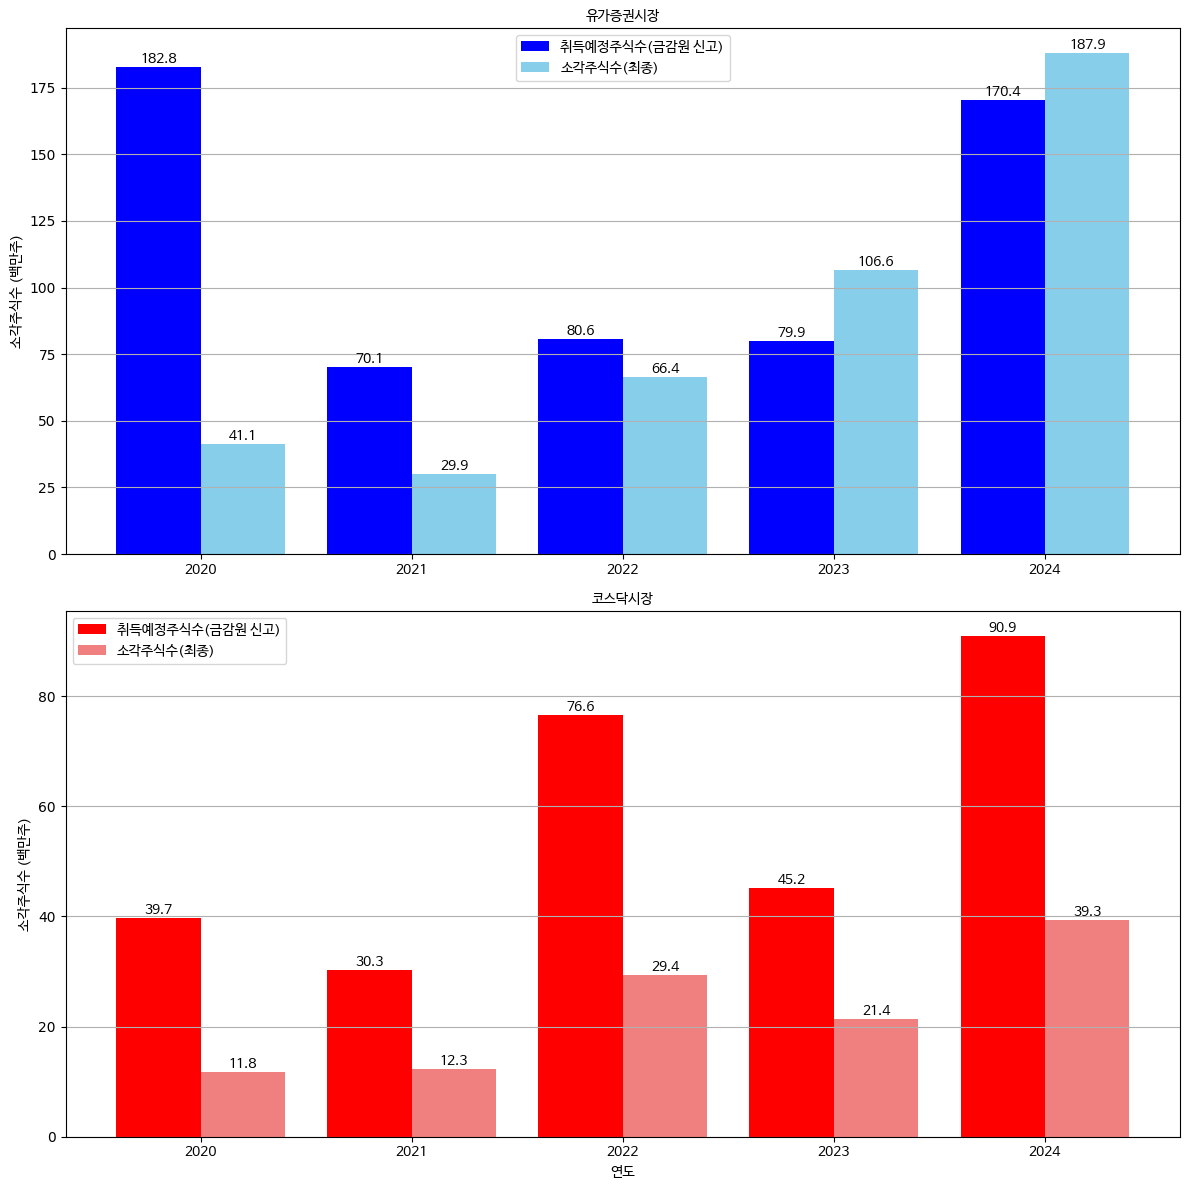

In [107]:
# STK와 KSQ 데이터 분리 (copy로 복사본 생성)
stk_data = grouped_df[grouped_df['marketType'] == 'STK'].copy()
ksq_data = grouped_df[grouped_df['marketType'] == 'KSQ'].copy()

stk_dart_data = grouped_df_dart[grouped_df_dart['marketType'] == 'STK'].copy()
ksq_dart_data = grouped_df_dart[grouped_df_dart['marketType'] == 'KSQ'].copy()

# 막대 너비 설정
bar_width = 0.4

# x축 위치 설정 (연도 기준)
x_stk = np.arange(len(stk_data['연도']))
x_ksq = np.arange(len(ksq_data['연도']))

# y축 값을 1,000,000으로 나누기 (백만 단위로 변환)
stk_data['발행주식수'] = stk_data['발행주식수'] / 1_000_000
ksq_data['발행주식수'] = ksq_data['발행주식수'] / 1_000_000
stk_dart_data['취득예정주식수(주)_보통주'] = stk_dart_data['취득예정주식수(주)_보통주'] / 1_000_000
ksq_dart_data['취득예정주식수(주)_보통주'] = ksq_dart_data['취득예정주식수(주)_보통주'] / 1_000_000

# 시각화: 서브플롯 생성
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# 상단: 유가증권시장(STK) 데이터
axes[0].bar(x_stk - bar_width / 2, stk_dart_data['취득예정주식수(주)_보통주'], bar_width, color='blue', label='취득예정주식수(금감원 신고)')
axes[0].bar(x_stk + bar_width / 2, stk_data['발행주식수'], bar_width, color='skyblue', label='소각주식수(최종)')

# x축 레이블과 막대 위 값 표시
axes[0].set_xticks(x_stk)
axes[0].set_xticklabels(stk_data['연도'], fontproperties=font)
for i, value in enumerate(stk_dart_data['취득예정주식수(주)_보통주']):
    axes[0].text(i - bar_width / 2, value, f'{value:,.1f}', ha='center', va='bottom', fontsize=10, fontproperties=font)
for i, value in enumerate(stk_data['발행주식수']):
    axes[0].text(i + bar_width / 2, value, f'{value:,.1f}', ha='center', va='bottom', fontsize=10, fontproperties=font)

axes[0].set_title('유가증권시장', fontproperties=font)
axes[0].set_ylabel('소각주식수 (백만주)', fontproperties=font)
axes[0].legend(title_fontproperties=font, prop=font)
axes[0].grid(axis='y')

# 하단: 코스닥시장(KSQ) 데이터
axes[1].bar(x_ksq - bar_width / 2, ksq_dart_data['취득예정주식수(주)_보통주'], bar_width, color='red', label='취득예정주식수(금감원 신고)')
axes[1].bar(x_ksq + bar_width / 2, ksq_data['발행주식수'], bar_width, color='lightcoral', label='소각주식수(최종)')

# x축 레이블과 막대 위 값 표시
axes[1].set_xticks(x_ksq)
axes[1].set_xticklabels(ksq_data['연도'], fontproperties=font)
for i, value in enumerate(ksq_dart_data['취득예정주식수(주)_보통주']):
    axes[1].text(i - bar_width / 2, value, f'{value:,.1f}', ha='center', va='bottom', fontsize=10, fontproperties=font)
for i, value in enumerate(ksq_data['발행주식수']):
    axes[1].text(i + bar_width / 2, value, f'{value:,.1f}', ha='center', va='bottom', fontsize=10, fontproperties=font)

axes[1].set_title('코스닥시장', fontproperties=font)
axes[1].set_xlabel('연도', fontproperties=font)
axes[1].set_ylabel('소각주식수 (백만주)', fontproperties=font)
axes[1].legend(title_fontproperties=font, prop=font)
axes[1].grid(axis='y')

# 레이아웃 조정 및 출력
plt.tight_layout()
plt.show()

# 개별 상장사 취득공시vs소각 수량 대조표 만들기

## 금감원 기준 회사별 종목코드를 불러오기
✔ 금감원 웹에서는 별도 종목코드를 맵핑하여 제공하지 않으므로, 별도 페이지에 가서 다운받음

In [24]:
# 유가 코스닥 시장 리스트
mkt_list = ['P', 'A']

# 비어있는 데이터프레임 생성
df_list_dart = pd.DataFrame()

for i in range(len(mkt_list)):
  mkt = mkt_list[i]
  # URL 설정
  url = f'https://dart.fss.or.kr/dsae001/downloadExcel.do?startDate=&endDate=&currentPage=1&maxResults=&maxLinks=&sort=&series=&selectKey=&searchIndex=&textCrpCik=&autoSearch=true&businessCode=all&bsnRgsNo=&bsnRgsNo_1=&bsnRgsNo_2=&bsnRgsNo_3=&crpRgsNo=&textCrpNm=&corporationType={mkt}'

  # 엑셀 파일 다운로드
  response = requests.get(url)
  excel_path = "/content/상장사목록.xlsx"  # 코랩 환경에서 임시 저장 경로

  # 파일 저장
  with open(excel_path, "wb") as f:
      f.write(response.content)

  # 엑셀 파일을 데이터프레임으로 읽기
  df_loop = pd.read_excel(excel_path)

  # 시장 구분자 삽입
  df_loop['mkt'] = mkt

  # 합치기
  df_list_dart = pd.concat([df_list_dart, df_loop], axis = 0)

/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [26]:
# 종목코드 열을 str 타입으로 변환하고 0으로 채우기 (예: 6자리)
if '종목코드' in df_list_dart.columns:
    df_list_dart['종목코드'] = df_list_dart['종목코드'].astype(str).str.zfill(6)

df_list_dart

,회사명,종목코드,mkt
0,AJ네트웍스,095570,P
1,AK홀딩스,006840,P
2,BGF,027410,P
3,BGF리테일,282330,P
4,BNK금융지주,138930,P
...,...,...,...
1775,흥구석유,024060,A
1776,흥국,010240,A
1777,흥국에프엔비,189980,A
1778,희림,037440,A


* 자사주 취득 공시수집 내용에 종목코드를 결합하기

In [52]:
df_dart_buyback_a_with_code = pd.merge(df_dart_buyback_a, df_list_dart[['회사명','종목코드']], on='회사명', how='left')
df_dart_buyback_a_with_code

,회사명,접수일,취득예정주식수(주)_보통주,연도,method,marketType,종목코드
0,AJ네트웍스,2021-06-09,468222.0,2021,otc,STK,095570
1,CNH,2020-03-20,413215.0,2020,mkt,KSQ,023460
2,CNH,2020-07-21,343642.0,2020,mkt,KSQ,023460
3,CNH,2020-08-12,460000.0,2020,mkt,KSQ,023460
4,CNH,2021-11-17,345000.0,2021,mkt,KSQ,023460
...,...,...,...,...,...,...,...
844,휴마시스,2024-03-18,17533607.0,2024,mkt,KSQ,205470
845,힘스,2021-01-25,147059.0,2021,mkt,KSQ,238490
846,힘스,2021-11-01,109770.0,2021,mkt,KSQ,238490
847,힘스,2022-02-03,113637.0,2022,mkt,KSQ,238490


In [59]:
# 혹시 결합이 안된 건이 있을지 확인
if len(df_dart_buyback_a_with_code[df_dart_buyback_a_with_code.종목코드.isna()]) == 0:
  print('없음')
else:
  df_dart_buyback_a_with_code[df_dart_buyback_a_with_code.종목코드.isna()]

없음


## 자기주식취득결정(금감원), 소각결과(거래소) 데이터 정리

# 거래소 기준의 자사주 취득/처분 통계 불러오기(2020~2024)
(장내 수량만 카운트 됨. 장외 자사주 취득은 카운트 안됨)

* 정보데이터시스템(data.krx.co.kr)에서 자동으로 자료 다운받기

In [99]:
st_y = '2020'
end_y = '2024'

#거래소 홈페이지에서 불러오기
#화면번호 20004(자사주취득/처분종목현황)
gen_otp_url = 'http://data.krx.co.kr/comm/fileDn/GenerateOTP/generate.cmd'
gen_otp_data = {
    'locale': 'ko_KR',
    'mktId': 'ALL',
    'tboxisuCd_finder_stkisu0_2': '전체',
    'isuCd': 'ALL',
    'isuCd2': 'ALL',
    'param1isuCd_finder_stkisu0_2': 'ALL',
    'trstkTpCd': 'ALL',
    'trstkAcqstdispTpCd': 'ALL',
    'strtDd': f'{st_y}0101',
    'endDd': f'{end_y}1224',
    'share': '1',
    'money': '1',
    'csvxls_isNo': 'false',
    'name': 'fileDown',
    'url': 'dbms/MDC/STAT/issue/MDCSTAT20601'
}

headers = {
    'Referer': 'http://data.krx.co.kr/contents/MDC/MDI/mdiLoader/index.cmd?menuId=MDC03010201',
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

otp = requests.post(gen_otp_url, gen_otp_data, headers = headers).text

down_url = 'http://data.krx.co.kr/comm/fileDn/download_csv/download.cmd'
down_content = requests.post(down_url, {'code': otp}, headers = headers)


df_buyback = pd.read_csv(BytesIO(down_content.content), encoding = 'EUC-KR')

In [100]:
# 확인해보기
print("행의 개수: " + str(len(df_buyback)))
df_buyback.tail()

행의 개수: 2734


,공시일,종목코드,종목명,시장구분,직접/신탁,취득/처분,취득(처분)예정기간_시작일,취득(처분)예정기간_종료일,신고내역_수량,신고내역_금액,체결내역(누계)_수량,체결내역(누계)_체결수량비율,체결내역(누계)_금액
2729,2020/01/10,086900,메디톡스,KOSDAQ,직접,취득,2020/01/13,2020/04/10,30000,9894000000,30000.0,100.00,9.490836e+09
2730,2020/01/08,003000,부광약품,KOSPI,직접,취득,2020/01/08,2020/04/07,1916000,25003800000,1740937.0,90.86,2.500143e+10
2731,2020/01/08,069410,엔텔스,KOSDAQ,직접,취득,2020/01/09,2020/04/08,50000,437500000,50000.0,100.00,3.891282e+08
2732,2020/01/02,192820,코스맥스,KOSPI,직접,취득,2020/01/03,2020/01/15,12500,998750000,12500.0,100.00,1.010378e+09
2733,2020/01/02,044820,코스맥스비티아이,KOSPI,직접,취득,2020/01/03,2020/01/15,20000,269000000,20000.0,100.00,2.848300e+08


* 연도별 유형별 취득수량/취득금액 구하기

In [101]:
# df_listed DataFrame 사용하여 연도별 유형별 취득수량/처분수량
# '공시일' 칼럼을 날짜형태로 변환
df_buyback['공시일'] = pd.to_datetime(df_buyback['공시일'])

# '공시일' 칼럼에서 연도를 뽑아내기
df_buyback['연도'] = df_buyback['공시일'].dt.year

# 필요한 칼럼만 남기기
df_buyback = df_buyback[['공시일', '종목코드', '종목명', '시장구분', '직접/신탁', '취득/처분', '체결내역(누계)_수량','연도']]

# 칼럼명 변경
df_buyback.columns = ['공시일', '종목코드', '회사명', 'marketType', '직접/신탁', '취득/처분', '체결수량', '연도']

# 시장구분자 통일
# 명시적 복사
df_buyback = df_buyback.copy()

# marketType 변경
df_buyback.loc[df_buyback['marketType'] == 'KOSPI', 'marketType'] = 'STK'
df_buyback.loc[df_buyback['marketType'] == 'KOSDAQ', 'marketType'] = 'KSQ'

# 시장구분: 유가
# 취득
con = df_buyback['취득/처분'] == '취득'
df_buyback = df_buyback[con]

df_buyback

,공시일,종목코드,회사명,marketType,직접/신탁,취득/처분,체결수량,연도
1,2024-12-24,078350,한양디지텍,KSQ,신탁,취득,50000.0,2024
2,2024-12-23,162300,신스틸,KSQ,신탁,취득,281580.0,2024
3,2024-12-23,290560,신시웨이,KSQ,신탁,취득,8540.0,2024
4,2024-12-20,092070,디엔에프,KSQ,신탁,취득,50314.0,2024
5,2024-12-20,006730,서부T&D,KSQ,직접,취득,80000.0,2024
...,...,...,...,...,...,...,...,...
2729,2020-01-10,086900,메디톡스,KSQ,직접,취득,30000.0,2020
2730,2020-01-08,003000,부광약품,STK,직접,취득,1740937.0,2020
2731,2020-01-08,069410,엔텔스,KSQ,직접,취득,50000.0,2020
2732,2020-01-02,192820,코스맥스,STK,직접,취득,12500.0,2020


# 취득예정 vs 장내취득 vs 소각수량 시각화

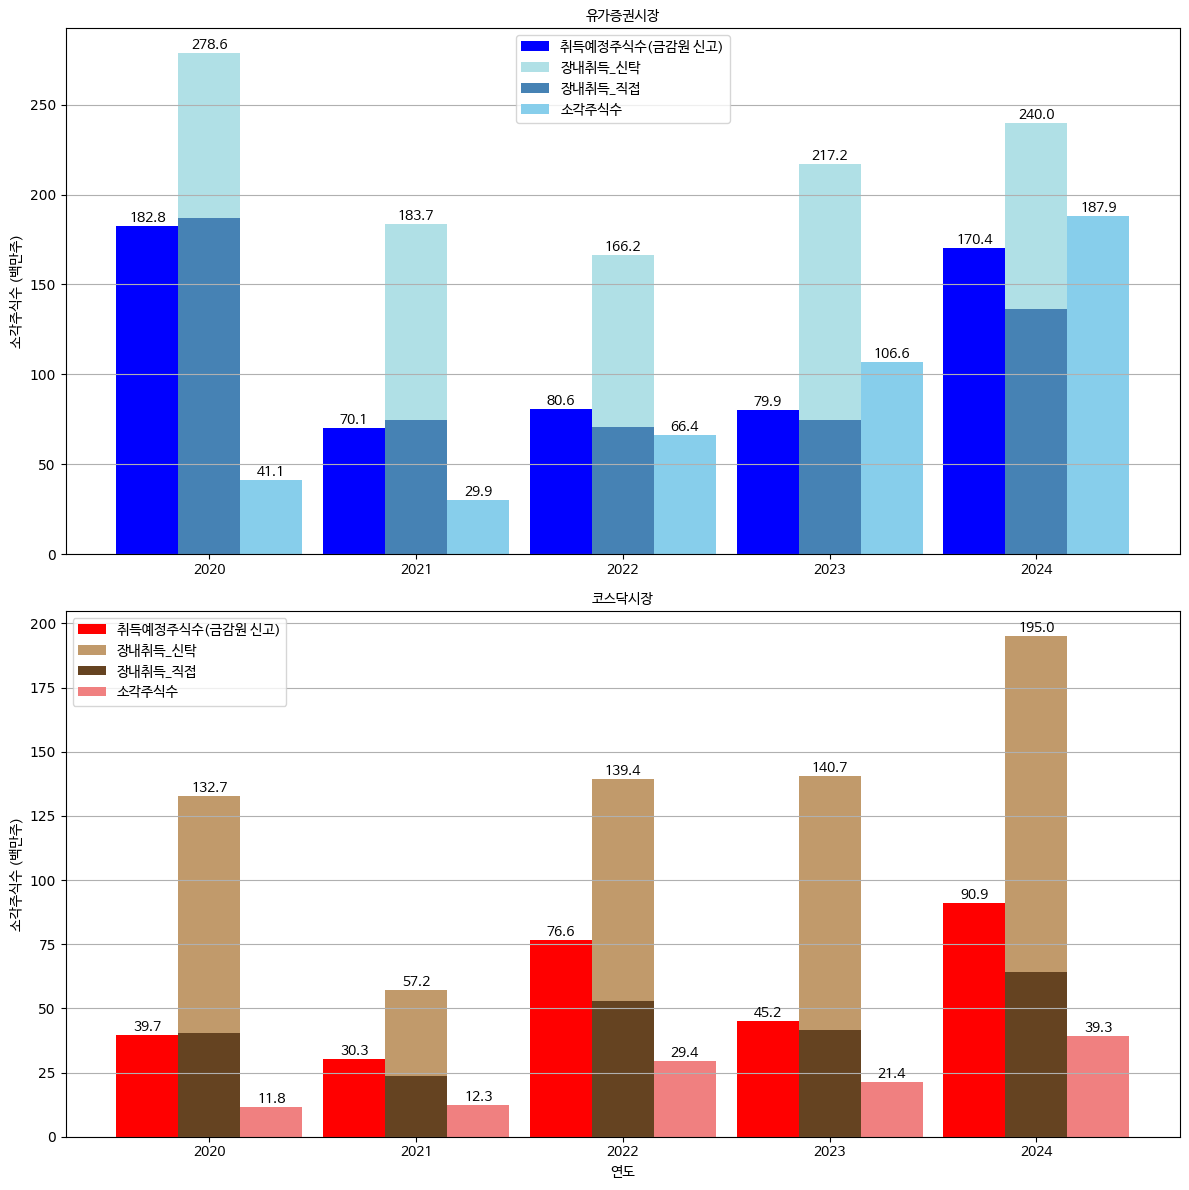

In [112]:
# STK, KSQ 데이터 분리 및 복사
stk_data = grouped_df[grouped_df['marketType'] == 'STK'].copy()
ksq_data = grouped_df[grouped_df['marketType'] == 'KSQ'].copy()

stk_dart_data = grouped_df_dart[grouped_df_dart['marketType'] == 'STK'].copy()
ksq_dart_data = grouped_df_dart[grouped_df_dart['marketType'] == 'KSQ'].copy()

stk_buyback = df_buyback[df_buyback['marketType'] == 'STK']
ksq_buyback = df_buyback[df_buyback['marketType'] == 'KSQ']

# 막대 너비 설정
bar_width = 0.3

# x축 위치 설정
x_stk = np.arange(len(stk_data['연도']))
x_ksq = np.arange(len(ksq_data['연도']))

# y축 값을 1,000,000으로 나누기 (백만 단위로 변환)
stk_data['발행주식수'] = stk_data['발행주식수'] / 1_000_000
ksq_data['발행주식수'] = ksq_data['발행주식수'] / 1_000_000
stk_dart_data['취득예정주식수(주)_보통주'] = stk_dart_data['취득예정주식수(주)_보통주'] / 1_000_000
ksq_dart_data['취득예정주식수(주)_보통주'] = ksq_dart_data['취득예정주식수(주)_보통주'] / 1_000_000

stk_buyback_grouped = stk_buyback.groupby(['연도', '직접/신탁'])['체결수량'].sum().unstack(fill_value=0) / 1_000_000
ksq_buyback_grouped = ksq_buyback.groupby(['연도', '직접/신탁'])['체결수량'].sum().unstack(fill_value=0) / 1_000_000

# 시각화: 서브플롯 생성
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# 상단: 유가증권시장 (STK)
axes[0].bar(x_stk - bar_width, stk_dart_data['취득예정주식수(주)_보통주'], bar_width, color='blue', label='취득예정주식수(금감원 신고)')
axes[0].bar(x_stk, stk_buyback_grouped['신탁'].values, bar_width, bottom=stk_buyback_grouped['직접'].values, color='#B0E0E6', label='장내취득_신탁')
axes[0].bar(x_stk, stk_buyback_grouped['직접'].values, bar_width, color='#4682B4', label='장내취득_직접')
axes[0].bar(x_stk + bar_width, stk_data['발행주식수'], bar_width, color='skyblue', label='소각주식수')

# 데이터 레이블 추가
for i, value in enumerate(stk_dart_data['취득예정주식수(주)_보통주']):
    axes[0].text(i - bar_width, value, f'{value:,.1f}', ha='center', va='bottom', fontsize=10, fontproperties=font)
for i, (direct, trust) in enumerate(zip(stk_buyback_grouped['직접'], stk_buyback_grouped['신탁'])):
    axes[0].text(i, direct + trust, f'{trust + direct:,.1f}', ha='center', va='bottom', fontsize=10, fontproperties=font)
for i, value in enumerate(stk_data['발행주식수']):
    axes[0].text(i + bar_width, value, f'{value:,.1f}', ha='center', va='bottom', fontsize=10, fontproperties=font)

# x축 레이블 추가 (유가증권시장)
axes[0].set_xticks(x_stk)
axes[0].set_xticklabels(stk_data['연도'], fontproperties=font)
axes[0].set_title('유가증권시장', fontproperties=font)
axes[0].set_ylabel('소각주식수 (백만주)', fontproperties=font)
axes[0].legend(title_fontproperties=font, prop=font)
axes[0].grid(axis='y')

# 하단: 코스닥시장 (KSQ)
axes[1].bar(x_ksq - bar_width, ksq_dart_data['취득예정주식수(주)_보통주'], bar_width, color='red', label='취득예정주식수(금감원 신고)')
axes[1].bar(x_ksq, ksq_buyback_grouped['신탁'].values, bar_width, bottom=ksq_buyback_grouped['직접'].values, color='#C19A6B', label='장내취득_신탁')
axes[1].bar(x_ksq, ksq_buyback_grouped['직접'].values, bar_width, color='#654321', label='장내취득_직접')
axes[1].bar(x_ksq + bar_width, ksq_data['발행주식수'], bar_width, color='lightcoral', label='소각주식수')

# 데이터 레이블 추가
for i, value in enumerate(ksq_dart_data['취득예정주식수(주)_보통주']):
    axes[1].text(i - bar_width, value, f'{value:,.1f}', ha='center', va='bottom', fontsize=10, fontproperties=font)
for i, (direct, trust) in enumerate(zip(ksq_buyback_grouped['직접'], ksq_buyback_grouped['신탁'])):
    axes[1].text(i, direct + trust, f'{trust + direct:,.1f}', ha='center', va='bottom', fontsize=10, fontproperties=font)
for i, value in enumerate(ksq_data['발행주식수']):
    axes[1].text(i + bar_width, value, f'{value:,.1f}', ha='center', va='bottom', fontsize=10, fontproperties=font)

# x축 레이블 추가 (코스닥시장)
axes[1].set_xticks(x_ksq)
axes[1].set_xticklabels(ksq_data['연도'], fontproperties=font)
axes[1].set_title('코스닥시장', fontproperties=font)
axes[1].set_xlabel('연도', fontproperties=font)
axes[1].set_ylabel('소각주식수 (백만주)', fontproperties=font)
axes[1].legend(title_fontproperties=font, prop=font)
axes[1].grid(axis='y')

# 레이아웃 조정 및 출력
plt.tight_layout()
plt.show()


In [67]:
df_result.to_excel('df_result.xlsx')

In [69]:
df_dart_buyback.to_excel('df_dart_buyback.xlsx')